In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
from collections import defaultdict
import pickle as pkl

from sklearn.preprocessing import minmax_scale
from scipy.stats import ttest_ind,combine_pvalues
from statsmodels.stats.multitest import multipletests

from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib.cm as cm
import matplotlib.colors as mcolors

import sys
sys.path.insert(0, '/lustre/groups/ml01/code/karin.hrovatin/diabetes_analysis/')
from importlib import reload  
import helper as h
reload(h)
import helper as h

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
path_rna='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/'
path_data=path_rna+'combined/'
path_clde=path_data+'beta_subtype_general/'
path_genes='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/gene_lists/'

In [3]:
# Saving figures
path_fig='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/figures/paper/'

In [4]:
# Orthologues
orthologues=pd.read_table(path_genes+'orthologues_ORGmus_musculus_ORG2homo_sapiens_V103.tsv'
                         ).rename(
    {'Gene name':'gs_mm','Human gene name':'gs_hs','Gene stable ID':'eid_mm'},axis=1)

In [17]:
# Lad DE
marker_info=pkl.load(open(path_clde+'markersCLparsed_leiden_r1.5_parsed_const_study_selected.pkl','rb'))
# Extract markers
markers_new=defaultdict(list)
for group,mm_eids in marker_info.items():
    # Match group to parsed cluster names
    #group=cl_map[group]
    markers_new[group]=set(orthologues.query('eid_mm in @mm_eids').gs_hs.to_list())
markers_new

defaultdict(list,
            {'imm.': {'PRKCA', 'SLC37A1', 'TOR3A'},
             'adult': {'PRSS53'},
             'agedF': {'B3GALT1', 'FBXW12', 'FMO1', 'NEB', 'TPH1'},
             'agedM': {'BMT2', 'DLGAP1', 'GAD1', 'IRS2', 'KIAA2026'},
             'NOD-D': {'IDNK', 'IRGM', 'PPA1'},
             'db/db+mSTZ': {'GAST', 'SERPINA7', 'SLC5A10', 'SORCS2', 'TAGLN3'},
             'chem': {'KIZ', 'PKN2'}})

In [15]:
# Known markers
markers_mm={
    'beta':['Ins1','Ins2','Nkx6-1','Pdx1'],
    'imm.':['Rbp4','Cd81','Mafb'],
    'mature':['Mafa','Ucn3','Slc2a2'],
    'aged':['Cdkn2a','Trp53bp1'],
    'T2D':['Gast','Gc','Aldh1a3','Cck','Aldob','Chgb'],
    'T1D':['B2m'],
    }
# Map to human
markers=defaultdict(set)
for group,gss_mm in markers_mm.items():
    markers[group].update(orthologues.query('gs_mm in @gss_mm')['gs_hs'])
print(markers)

defaultdict(<class 'set'>, {'beta': {'INS', 'PDX1', 'NKX6-1'}, 'imm.': {'CD81', 'RBP4', 'MAFB'}, 'mature': {'UCN3', 'MAFA', 'SLC2A2'}, 'aged': {'TP53BP1'}, 'T2D': {'GC', 'CHGB', 'ALDOB', 'ALDH1A3', 'GAST', 'CCK'}, 'T1D': {'B2M'}})


## Marker DE OvR
Compute OvR DE of markers to summarise their performance across datasets. In each dataset group donors in groups that should correspond either to population expected to be high in a marker or "rest" of the donors. Only datasets that have the group expected to be high in a marker are used for that marker (i.e. computation of DE is on per-dataset level).

Queries for groups of cells expected to be high in above specified marker groups

In [18]:
group_queries={
    'T1D':'disease=="T1D"',
    'T2D':'disease=="T2D"',
    'adult':'disease=="healthy" & 19<=age_years<=64',
    'mature': 'disease=="healthy" & 19<=age_years', # Contains both adult and aged
    'agedF':'disease=="healthy" & 65<=age_years & sex=="female"',
    'agedM':'disease=="healthy" & 65<=age_years & sex=="male"',
    'aged':'disease=="healthy" & 65<=age_years',
    'imm.':'disease=="healthy" & age_years<=18',
}
# Add group queries for other groups
group_queries['NOD-D']=group_queries['T1D']
group_queries['db/db+mSTZ']=group_queries['T2D']

Compute DE

In [6]:
# Do not use groups with less than this N cells
min_cells=5

In [19]:
# Compute OvR DE for markers
de_results=[]
for dataset,ddir in [('GSE83139','GSE83139/GEO/'),
                    ('GSE154126','GSE154126/GEO/'),
                    ('GSE101207','GSE101207/GEO/'),
                    ('GSE124742_GSE164875_patch','GSE124742_GSE164875/GEO/patch/'),
                    ('GSE124742_GSE164875_FACS','GSE124742_GSE164875/GEO/FACS/'),
                    ('GSE86469','GSE86469/GEO/'),
                    ('GSE81547','GSE81547/GEO/'),
                    ('GSE198623','P21000/sophie/human/'),
                    ('GSE81608','GSE81608/GEO/'),
                    ('GSE148073','GSE148073/GEO/')
                    ]:
    # Load adata
    print(dataset)
    adata=sc.read(path_rna+ddir+'adata_filtered.h5ad')
    # Subset to beta cells and disease phenotypes (removing pre pehnotypes)
    adata=adata[(adata.obs.cell_type=='beta').values& 
                (adata.obs.disease.isin(['healthy','T1D','T2D'])).values].copy()
    print(adata.shape)
    adata.obs['age_years']=adata.obs.age.apply(lambda x: h.age_years(x)).astype(float)
    if 'gene_symbol' in adata.var.columns:
        adata.var_names=adata.var.gene_symbol

    de_res=[]
    for marker_collection,marker_groups in [('known',markers),('new',markers_new)]:
        for group,genes in marker_groups.items():
            if group in group_queries:
                cells_group=set(adata.obs.query(group_queries[group]).index)
                cells_rest=[ c for c in adata.obs_names if c not in cells_group]
                if len(cells_group)>=min_cells and len(cells_rest)>=min_cells:
                    for gene in genes:
                        if gene in adata.var_names:
                            # Compute OvR DE
                            x_group=adata[list(cells_group),gene].X.todense()
                            x_rest=adata[cells_rest,gene].X.todense()
                            # If both groups are all 0 set lfc to 0 and pval to 1
                            if (x_group==0).all() and (x_rest==0).all():
                                p=1
                                lfc=0
                            else:
                                p=ttest_ind(x_group,x_rest,alternative='greater').pvalue[0]
                                lfc=np.log2((x_group.mean()+ 1e-9)/(x_rest.mean()+ 1e-9))
                            ratio_group=(x_group!=0).sum()/x_group.shape[0]
                            de_res.append({
                                'dataset':dataset,
                                'marker_collection':marker_collection,
                                'group':group,
                                'gene':gene,
                                'lfc':lfc,
                                'pval':p,
                                'ratio_group':ratio_group
                            })
    de_res=pd.DataFrame(de_res)
    display(de_res)
    de_results.append(de_res)
de_results=pd.concat(de_results)

GSE83139
(111, 19950)


,dataset,marker_collection,group,gene,lfc,pval,ratio_group
0,GSE83139,known,imm.,CD81,-0.158394,0.756702,1.0
1,GSE83139,known,imm.,RBP4,0.883363,0.000004,1.0
2,GSE83139,known,imm.,MAFB,0.359032,0.007298,1.0
3,GSE83139,known,mature,UCN3,-0.790574,0.913960,1.0
4,GSE83139,known,mature,MAFA,-0.607269,0.999032,1.0
5,GSE83139,known,mature,SLC2A2,0.203610,0.338922,1.0
6,GSE83139,known,T2D,GC,0.994581,0.000156,1.0
7,GSE83139,known,T2D,CHGB,0.147347,0.002704,1.0
8,GSE83139,known,T2D,ALDOB,-1.414663,0.976915,1.0
9,GSE83139,known,T2D,ALDH1A3,0.573188,0.066615,1.0


GSE154126
(182, 21152)


,dataset,marker_collection,group,gene,lfc,pval,ratio_group
0,GSE154126,known,imm.,CD81,0.025081,4.228734e-01,0.915789
1,GSE154126,known,imm.,RBP4,0.841735,1.708961e-13,0.989474
2,GSE154126,known,imm.,MAFB,0.034234,3.666582e-01,0.936842
3,GSE154126,known,mature,UCN3,-0.358260,6.837999e-01,0.097561
4,GSE154126,known,mature,MAFA,-0.000112,5.002141e-01,0.707317
5,GSE154126,known,mature,SLC2A2,-0.106708,5.950528e-01,0.292683
6,GSE154126,known,T2D,GC,0.848054,3.132037e-06,0.891304
7,GSE154126,known,T2D,CHGB,0.046673,1.001573e-01,1.000000
8,GSE154126,known,T2D,ALDOB,-0.853746,8.635290e-01,0.108696
9,GSE154126,known,T2D,ALDH1A3,1.568533,3.739659e-03,0.282609


GSE101207
(9958, 20485)


,dataset,marker_collection,group,gene,lfc,pval,ratio_group
0,GSE101207,known,mature,UCN3,-0.899784,0.963425,0.013717
1,GSE101207,known,mature,MAFA,0.900301,0.000087,0.118018
2,GSE101207,known,mature,SLC2A2,2.377677,0.000644,0.018908
3,GSE101207,known,T2D,GC,-1.441797,0.917212,0.004823
4,GSE101207,known,T2D,CHGB,0.612067,0.000000,0.741158
5,GSE101207,known,T2D,ALDOB,3.253966,0.000116,0.005359
6,GSE101207,known,T2D,ALDH1A3,-16.868740,0.813842,0.000000
7,GSE101207,known,T2D,GAST,-11.368007,0.684448,0.000000
8,GSE101207,known,T2D,CCK,0.000000,1.000000,0.000000
9,GSE101207,new,adult,PRSS53,0.686538,0.202630,0.006426


GSE124742_GSE164875_patch
(496, 45305)


,dataset,marker_collection,group,gene,lfc,pval,ratio_group
0,GSE124742_GSE164875_patch,known,imm.,CD81,-0.128207,8.283553e-01,0.754717
1,GSE124742_GSE164875_patch,known,imm.,RBP4,0.630269,1.817975e-05,0.905660
2,GSE124742_GSE164875_patch,known,imm.,MAFB,0.060100,3.215138e-01,0.830189
3,GSE124742_GSE164875_patch,known,mature,UCN3,-0.430652,9.950771e-01,0.425926
4,GSE124742_GSE164875_patch,known,mature,MAFA,-0.180182,9.469262e-01,0.697531
5,GSE124742_GSE164875_patch,known,mature,SLC2A2,0.529554,4.284065e-02,0.237654
6,GSE124742_GSE164875_patch,known,aged,TP53BP1,0.031142,4.363204e-01,0.653061
7,GSE124742_GSE164875_patch,known,T2D,GC,-0.530950,7.557771e-01,0.065421
8,GSE124742_GSE164875_patch,known,T2D,CHGB,0.106345,6.228547e-04,1.000000
9,GSE124742_GSE164875_patch,known,T2D,ALDOB,0.728563,1.730950e-01,0.056075


GSE124742_GSE164875_FACS
(674, 48925)


,dataset,marker_collection,group,gene,lfc,pval,ratio_group
0,GSE124742_GSE164875_FACS,known,mature,UCN3,0.510453,3.156680e-02,0.319066
1,GSE124742_GSE164875_FACS,known,mature,MAFA,0.326201,3.145512e-02,0.546693
2,GSE124742_GSE164875_FACS,known,mature,SLC2A2,1.702076,1.832593e-04,0.202335
3,GSE124742_GSE164875_FACS,known,aged,TP53BP1,-0.922793,9.954234e-01,0.433333
4,GSE124742_GSE164875_FACS,known,T2D,GC,-0.277611,7.188451e-01,0.106250
5,GSE124742_GSE164875_FACS,known,T2D,CHGB,-0.095679,9.997071e-01,0.981250
6,GSE124742_GSE164875_FACS,known,T2D,ALDOB,2.203894,4.590905e-15,0.318750
7,GSE124742_GSE164875_FACS,known,T2D,ALDH1A3,1.287116,2.451575e-01,0.006250
8,GSE124742_GSE164875_FACS,known,T2D,GAST,-25.139898,9.116996e-01,0.000000
9,GSE124742_GSE164875_FACS,known,T2D,CCK,-1.408082,7.082192e-01,0.006250


GSE86469


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


(264, 26616)


,dataset,marker_collection,group,gene,lfc,pval,ratio_group
0,GSE86469,known,mature,UCN3,-0.688469,0.917498,0.142857
1,GSE86469,known,mature,MAFA,0.353305,0.012145,0.755952
2,GSE86469,known,mature,SLC2A2,1.536180,0.000013,0.446429
3,GSE86469,known,T2D,GC,-1.356379,0.874662,0.020833
4,GSE86469,known,T2D,CHGB,0.106941,0.000026,1.000000
5,GSE86469,known,T2D,ALDOB,-0.126138,0.551302,0.083333
6,GSE86469,known,T2D,ALDH1A3,-1.914128,0.973199,0.031250
7,GSE86469,known,T2D,GAST,-23.559090,0.837555,0.000000
8,GSE86469,known,T2D,CCK,0.000000,1.000000,0.000000
9,GSE86469,new,adult,PRSS53,0.175286,0.329031,0.285714


GSE81547
(348, 23459)


,dataset,marker_collection,group,gene,lfc,pval,ratio_group
0,GSE81547,known,imm.,CD81,-1.051686,1.000000e+00,0.452381
1,GSE81547,known,imm.,RBP4,1.096068,3.961023e-22,0.920635
2,GSE81547,known,imm.,MAFB,-0.505936,9.953136e-01,0.420635
3,GSE81547,known,mature,UCN3,-0.638976,7.941647e-01,0.036036
4,GSE81547,known,mature,MAFA,0.289285,1.539125e-01,0.346847
5,GSE81547,known,mature,SLC2A2,0.092340,4.000507e-01,0.202703
6,GSE81547,new,imm.,PRKCA,-1.081303,9.971199e-01,0.111111
7,GSE81547,new,imm.,SLC37A1,-0.927293,9.895369e-01,0.126984
8,GSE81547,new,imm.,TOR3A,0.120318,3.697355e-01,0.166667
9,GSE81547,new,adult,PRSS53,1.738919,1.665575e-01,0.018018


GSE198623
(11923, 32738)


,dataset,marker_collection,group,gene,lfc,pval,ratio_group
0,GSE198623,known,aged,TP53BP1,-0.562377,1.000000,0.182911
1,GSE198623,new,adult,PRSS53,0.506704,0.196100,0.003088
2,GSE198623,new,agedF,NEB,0.491768,0.196251,0.003136
3,GSE198623,new,agedF,FBXW12,-0.707755,0.632694,0.000261
4,GSE198623,new,agedF,FMO1,0.269731,0.451132,0.000261
5,GSE198623,new,agedF,B3GALT1,0.825025,0.000013,0.027437
6,GSE198623,new,agedF,TPH1,-0.317036,0.861952,0.010713


GSE81608
(503, 39851)


/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/anndata/_core/anndata.py:891: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['A1BG', 'A2M', 'A2MP1', 'NAT1', 'NAT2']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "var")


,dataset,marker_collection,group,gene,lfc,pval,ratio_group
0,GSE81608,known,mature,UCN3,-0.715223,9.172390e-01,0.067633
1,GSE81608,known,mature,MAFA,-0.245364,9.939387e-01,0.768116
2,GSE81608,known,mature,SLC2A2,1.779840,1.839532e-08,0.285024
3,GSE81608,known,aged,TP53BP1,-0.259714,7.574507e-01,1.000000
4,GSE81608,known,T2D,GC,0.192925,3.275019e-01,0.175676
5,GSE81608,known,T2D,CHGB,0.121032,1.384827e-06,1.000000
6,GSE81608,known,T2D,ALDOB,-0.197071,5.852062e-01,0.064189
7,GSE81608,known,T2D,ALDH1A3,-0.402018,6.841453e-01,0.047297
8,GSE81608,known,T2D,GAST,-0.432918,5.923175e-01,0.003378
9,GSE81608,known,T2D,CCK,0.000000,1.000000e+00,0.000000


GSE148073
(4229, 26163)


,dataset,marker_collection,group,gene,lfc,pval,ratio_group
0,GSE148073,known,imm.,CD81,1.397129,0.000000e+00,0.876518
1,GSE148073,known,imm.,RBP4,1.185386,0.000000e+00,0.831984
2,GSE148073,known,imm.,MAFB,0.223564,3.095744e-03,0.520243
3,GSE148073,known,mature,UCN3,-0.364112,9.999653e-01,0.297673
4,GSE148073,known,mature,MAFA,0.282803,3.553707e-04,0.384009
5,GSE148073,known,mature,SLC2A2,-0.531094,9.887729e-01,0.060435
6,GSE148073,known,T1D,B2M,0.247607,0.000000e+00,0.977591
7,GSE148073,new,imm.,PRKCA,0.682178,2.240861e-05,0.157895
8,GSE148073,new,imm.,SLC37A1,0.085245,3.395455e-01,0.121457
9,GSE148073,new,imm.,TOR3A,0.824244,6.393791e-17,0.390688


In [20]:
# Are any results missing/inf
display(de_results[de_results.isna().any(axis=1)])
display(de_results[np.isinf(de_results[['lfc','pval','ratio_group']]).any(axis=1)])

,dataset,marker_collection,group,gene,lfc,pval,ratio_group


,dataset,marker_collection,group,gene,lfc,pval,ratio_group


Plot DE result of each marker across datasets

In [21]:
# Add pval log for plotting
de_results['-log10(pval)']=-np.log10(de_results.pval)
de_results.rename({'lfc':'lFC','ratio_group':'ratio of cells\nin group'},axis=1,inplace=True)
de_results['significant']=de_results.pval<0.05
# Order genes for plotting - UNUSED - resorted below
de_results['gene']=pd.Categorical(
    de_results['gene'],  
    sorted(pd.Series([m for  mc in (markers.values(),markers_new.values()) for ms in mc for m in ms]
             ).drop_duplicates().to_list()),
    ordered=True)

/home/icb/karin.hrovatin/miniconda3/envs/rpy2_3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<ipython-input-22-0866bb3306e7>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['gene_idx']=data.gene.map(gene_map)
<ipython-input-22-0866bb3306e7>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['gene_idx']=data.gene_idx+ np.random.normal(0,0.1,data.gene_idx.shape)
<ipython-input-22-0866bb3306e7>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

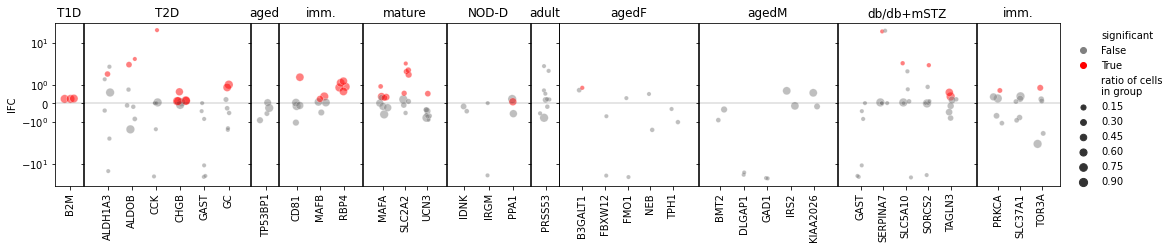

In [22]:
# Plot genes per group
# Plot known and new markers in the same line for a smaller plot
lp_min=de_results['-log10(pval)'].min()
lp_max=de_results['-log10(pval)'].max()
rg_min=de_results['ratio of cells\nin group'].min()
rg_max=de_results['ratio of cells\nin group'].max()
# N genes= n gridspec total, allow each ax as much place in gridspec as it has genes
genes_per_group=de_results.groupby(['marker_collection','group']).gene.nunique()
fig, axs = plt.subplots(nrows=1, ncols=genes_per_group.shape[0], sharex='col', sharey=True,
                               gridspec_kw={'width_ratios':genes_per_group.values,
                                           'wspace':0.01},
                               figsize=(genes_per_group.values.sum()*0.5, 3))
for idx,(collection,group) in enumerate(genes_per_group.index):
    data=de_results.query('marker_collection==@collection & group==@group')
    # Map genes to numbers to allow scatter computation along x
    genes=sorted(data.gene.unique())
    gene_map=dict(zip(genes,range(len(genes))))
    data['gene_idx']=data.gene.map(gene_map)
    data['gene_idx']=data.gene_idx+ np.random.normal(0,0.1,data.gene_idx.shape)
    ax=axs[idx]
    # 0 lfc mark
    ax.axhline(0,lw=0.2,c='k')
    # Plot genes
    legend=False if idx<genes_per_group.shape[0]-1 else 'auto'
    sb.scatterplot(x='gene_idx',y='lFC',hue='significant',size='ratio of cells\nin group',data=data,ax=ax,
                   # Specify colormap as else  may differ across subplots
                   legend=legend,palette={False:'gray',True:'red'},
                   #hue_norm=(lp_min,lp_max),
                   size_norm=(rg_min,rg_max),alpha=0.5)
    ax.set_yscale('symlog')
    ax.set_title(group)
    ax.margins(x=1/data.gene.nunique())
    # Map x labels back to genes
    ax.set_xticks(list(range(len(genes))))
    ax.set_xticklabels(labels=genes)   
    plt.setp(ax.get_xticklabels(),rotation=90) 
    
    ax.set_xlabel('')
    # Legend only at the end
    if legend!=False:
        l=plt.legend(bbox_to_anchor=(1.05,1.01),frameon=False)
    ax.set(facecolor = (0,0,0,0))
plt.savefig(path_fig+'scatter_beta_CLcoarse_human.png',dpi=300,bbox_inches='tight')

Keep in mind: The above significance isnt padj based.